# 1. Build a Neural network with Hyper-parameter fine tuning model

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch

In [2]:
# Load the Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
data = pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=iris['feature_names'] + ['target'])

In [3]:
# Preprocess the data
X = data.drop('target', axis=1)
y = LabelEncoder().fit_transform(data['target'])
y = to_categorical(y)

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Define the model building function
def build_model(hp):
    model = keras.Sequential()
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu', input_dim=X_train.shape[1]))
    
    # Tune the number of layers
    hp_layers = hp.Int('num_layers', min_value=1, max_value=3)
    for _ in range(hp_layers):
        model.add(keras.layers.Dense(units=hp_units, activation='relu'))

    model.add(keras.layers.Dense(3, activation='softmax'))  # 3 classes for Iris dataset

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [6]:
# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='hyperparameter_tuning',
    project_name='iris_tuning'
)

Reloading Tuner from hyperparameter_tuning\iris_tuning\tuner0.json


In [7]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [8]:
tuner.results_summary()

Results summary
Results in hyperparameter_tuning\iris_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
units: 256
num_layers: 1
learning_rate: 0.01
Score: 1.0

Trial 0 summary
Hyperparameters:
units: 416
num_layers: 2
learning_rate: 0.001
Score: 1.0

Trial 1 summary
Hyperparameters:
units: 128
num_layers: 2
learning_rate: 0.001
Score: 1.0

Trial 2 summary
Hyperparameters:
units: 128
num_layers: 1
learning_rate: 0.01
Score: 0.9666666388511658

Trial 3 summary
Hyperparameters:
units: 288
num_layers: 1
learning_rate: 0.0001
Score: 0.8333333134651184


In [9]:
# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

In [10]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 67843 (265.01 KB)
Trainable params: 67843 (265.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Print the best hyperparameters
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print("Best Hyperparameters:", best_hyperparameters)

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Best Hyperparameters: {'units': 256, 'num_layers': 1, 'learning_rate': 0.01}


1/1 [==============================] - 1s 515ms/step - loss: 0.0919 - accuracy: 1.0000
Test Accuracy: 1.0


# 2. Build an image classifier model with Pytorch

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

In [13]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

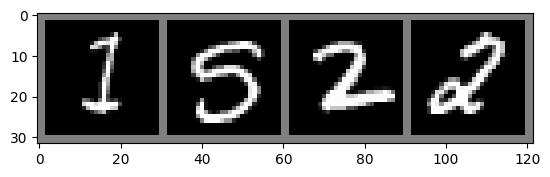

1     5     2     2    


In [14]:
# Displaying Images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [15]:
# Neural Network Model

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [16]:
# Loss and Optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
# Training the Model
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.147
[1,  4000] loss: 0.210
[1,  6000] loss: 0.153
[1,  8000] loss: 0.117
[1, 10000] loss: 0.108
[1, 12000] loss: 0.086
[1, 14000] loss: 0.091
[2,  2000] loss: 0.072
[2,  4000] loss: 0.073
[2,  6000] loss: 0.063
[2,  8000] loss: 0.072
[2, 10000] loss: 0.061
[2, 12000] loss: 0.066
[2, 14000] loss: 0.053
Finished Training


In [18]:
# Save the trained model
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)
print(f"Model saved at: {PATH}")

Model saved at: ./mnist_net.pth


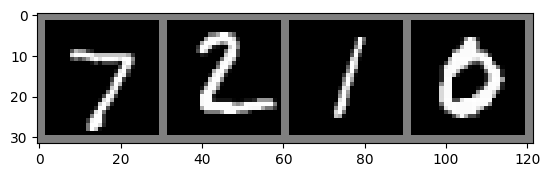

Predicted:  7     2     1     0    


In [19]:
# Testing the Model
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [20]:
# Load the saved model
loaded_net = Net()
loaded_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
outputs = loaded_net(images)

In [22]:
_, predicted = torch.max(outputs, 1)

# Print predicted classes
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  7     2     1     0    


In [23]:
# Model Evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 98.2%


In [24]:
# Class-wise Accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 99.5 %
Accuracy for class: 1     is 97.9 %
Accuracy for class: 2     is 99.1 %
Accuracy for class: 3     is 99.2 %
Accuracy for class: 4     is 99.4 %
Accuracy for class: 5     is 98.7 %
Accuracy for class: 6     is 98.0 %
Accuracy for class: 7     is 98.3 %
Accuracy for class: 8     is 99.6 %
Accuracy for class: 9     is 92.5 %
